# Ya hemos sacado modelos a nivel cliente con AUTOARIMA y PROPHET

# VAMOS A HACER REGRESIONES. 

# Empezamos por los estacionales
       df_SI_est.to_csv('data/df_SI_est.csv',sep='|',index=False)

In [1]:
#!pip install yellowbrick

In [2]:
# Importing libraries
import numpy as np 
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm
# Hide unnecessary warnings
import warnings
warnings.filterwarnings('ignore')
# Clustering
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
pd.plotting.register_matplotlib_converters()
import math
from matplotlib import gridspec
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Recuperamos los fciheros anteriores de estacionalidad y no estacionalidad que son con los que vamos a trabajar
    # ya no hace falta tener fecha como indice, pero si como columna

df_SI_est=pd.read_csv('data/df_SI_est.csv',sep='|')

# df_NO_est=pd.read_csv('data/df_NO_est.csv',sep='|')
# df_est_total=pd.read_csv('data/df_est_total.csv',sep='|')

df_SI_est.head()


,Fecha,id_cl,anno,mes,importe1,importe2,facturacion_ant,capital,gastos_personal,impuesto_sociedades,...,imp_7m,imp_8m,imp_9m,imp_10m,imp_11m,imp_12m,slope,intercept,trend,estacional
0,2017-01-01,2113,2017,1,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,si
1,2017-02-01,2113,2017,2,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,si
2,2017-03-01,2113,2017,3,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,si
3,2017-04-01,2113,2017,4,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,si
4,2017-05-01,2113,2017,5,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,si


In [4]:
df_SI_est.dtypes

Fecha                   object
id_cl                    int64
anno                     int64
mes                      int64
importe1               float64
importe2               float64
facturacion_ant        float64
capital                float64
gastos_personal        float64
impuesto_sociedades    float64
cod_sector             float64
des_sector              object
provincia                int64
rama_actividad          object
desc_actividad          object
PIB                    float64
cotiz_empleadores      float64
imp2_tot_cl            float64
peso_imp2              float64
imp_2m                 float64
imp_3m                 float64
imp_4m                 float64
imp_5m                 float64
imp_6m                 float64
imp_7m                 float64
imp_8m                 float64
imp_9m                 float64
imp_10m                float64
imp_11m                float64
imp_12m                float64
slope                  float64
intercept              float64
trend   

In [5]:
# Pasamos el id_cliente a string
#df_SI_est["id_cl"] = df_SI_est["id_cl"].apply(str)
#df_SI_est['imp_1m'] = data['importe2'].shift(1)

In [6]:
# Creamo el valor del mes anterior que es el que nos falta y la dif
df_SI_est['imp_1m'] = df_SI_est['importe2'].shift(1)
df_SI_est ['dif_1m']=df_SI_est['importe2']-df_SI_est['imp_1m']
df_SI_est.head()

,Fecha,id_cl,anno,mes,importe1,importe2,facturacion_ant,capital,gastos_personal,impuesto_sociedades,...,imp_9m,imp_10m,imp_11m,imp_12m,slope,intercept,trend,estacional,imp_1m,dif_1m
0,2017-01-01,2113,2017,1,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,si,NaN,NaN
1,2017-02-01,2113,2017,2,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,si,0.0,0.0
2,2017-03-01,2113,2017,3,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,si,0.0,0.0
3,2017-04-01,2113,2017,4,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,si,0.0,0.0
4,2017-05-01,2113,2017,5,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,si,0.0,0.0


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer


In [8]:
# Pivotamos la tabla quedandonos con la diferencia de importe del ultimo mes
df_scaled_SI = pd.DataFrame()
scaler = StandardScaler()

Data_prueba = df_SI_est.loc[:,['id_cl','Fecha','importe2']]

for cliente, df_cl_imp2 in list(Data_prueba.groupby('id_cl'))[:]:
    df_cl_imp2 = df_cl_imp2.reset_index()
    scaled =df_cl_imp2 ['importe2']
    lista = []
    for i in range(len(scaled)):
            lista.append([scaled[i]])

    scaled_array = scaler.fit_transform(lista)
    df_cl_imp2['imp_scaled'] = scaled_array
    df_scaled_SI = df_scaled_SI.append(df_cl_imp2,ignore_index=True)


df_scaled_SI
                                

,index,id_cl,Fecha,importe2,imp_scaled
0,0,2113,2017-01-01,0.0,-1.511566
1,1,2113,2017-02-01,0.0,-1.511566
2,2,2113,2017-03-01,0.0,-1.511566
3,3,2113,2017-04-01,0.0,-1.511566
4,4,2113,2017-05-01,0.0,-1.511566
...,...,...,...,...,...
314023,314023,175444,2019-08-01,658.0,-2.100292
314024,314024,175444,2019-09-01,1054.0,-1.192333
314025,314025,175444,2019-10-01,1880.0,0.701541
314026,314026,175444,2019-11-01,1678.0,0.238390


In [9]:
df_scaled_SI["Fecha"] = pd.to_datetime(df_scaled_SI["Fecha"])
df_scaled_SI.tail()

,index,id_cl,Fecha,importe2,imp_scaled
314023,314023,175444,2019-08-01,658.0,-2.100292
314024,314024,175444,2019-09-01,1054.0,-1.192333
314025,314025,175444,2019-10-01,1880.0,0.701541
314026,314026,175444,2019-11-01,1678.0,0.238390
314027,314027,175444,2019-12-01,1674.0,0.229219


In [10]:
df_scaled_SI2=df_scaled_SI.drop(['importe2'],axis=1)
df_scaled_SI2.head()

,index,id_cl,Fecha,imp_scaled
0,0,2113,2017-01-01,-1.511566
1,1,2113,2017-02-01,-1.511566
2,2,2113,2017-03-01,-1.511566
3,3,2113,2017-04-01,-1.511566
4,4,2113,2017-05-01,-1.511566


In [11]:
# Trasponemos
#df_copia3_tras = df_copia3.pivot(index='id_cl', columns='Fecha', values='importe2')
df_scaled_SI_T=df_scaled_SI.pivot(index='id_cl', columns='Fecha', values='importe2')
df_scaled_SI_T['id_cl']=df_scaled_SI_T.index
df_scaled_SI_T.head()

Fecha,2017-01-01 00:00:00,2017-02-01 00:00:00,2017-03-01 00:00:00,2017-04-01 00:00:00,2017-05-01 00:00:00,2017-06-01 00:00:00,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,...,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00,2019-09-01 00:00:00,2019-10-01 00:00:00,2019-11-01 00:00:00,2019-12-01 00:00:00,id_cl
id_cl,,,,,,,,,,,,,,,,,,,,,
2113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,46.0,47.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,2113
2204,0.0,0.0,23.0,21.0,19.0,18.0,16.0,14.0,12.0,10.0,...,15.0,10.0,5.0,15.0,10.0,5.0,18.0,12.0,6.0,2204
2228,1309.0,1244.0,1249.0,1281.0,1270.0,1310.0,1456.0,1535.0,1561.0,1472.0,...,1150.0,1207.0,1186.0,1239.0,1386.0,1285.0,1169.0,1244.0,1312.0,2228
2324,5.0,8.0,6.0,6.0,6.0,6.0,3.0,4.0,6.0,10.0,...,15.0,14.0,14.0,13.0,12.0,12.0,11.0,11.0,8.0,2324
2328,717.0,0.0,771.0,711.0,662.0,543.0,852.0,1042.0,986.0,853.0,...,1352.0,857.0,1194.0,957.0,903.0,830.0,999.0,836.0,345.0,2328


In [12]:
df_scaled_SI_T.to_csv('data/TFM_SI_escalado.csv',sep='|',index=False)

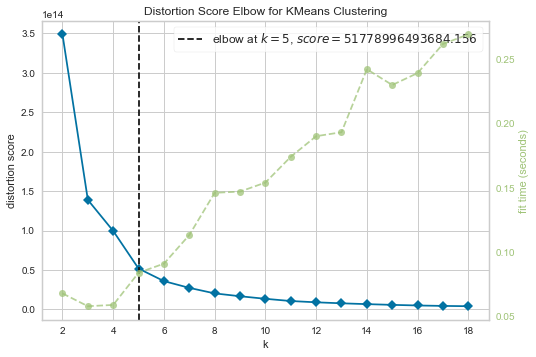

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [13]:
model = KMeans(init='k-means++') # esto crea el modelo
visualizer = KElbowVisualizer(model, k=(2,19),metric="distortion") # establecemos un rango de Kluster de 20 a 30
visualizer.fit(df_scaled_SI_T.iloc[:,1:]) 
visualizer.show()
# del dibujo sacamos que el numero de clusters es 24

In [14]:
# Clustering with 24 clusters
kmeans = KMeans(n_clusters=5,init='k-means++',random_state=0)  
y_kmeans = kmeans.fit_predict(df_scaled_SI_T.iloc[:,1:])  
df_scaled_SI_T["Cluster"] = y_kmeans

In [15]:
for i in range(0,5):
    print("Clients in cluster {} are {}".format(i,list(df_scaled_SI_T[df_scaled_SI_T.Cluster==i]["id_cl"].unique())))

Clients in cluster 0 are [2113, 2204, 2228, 2324, 2328, 2370, 2444, 2468, 2486, 2530, 2531, 2564, 2567, 2624, 2657, 2680, 2739, 2761, 2890, 2903, 2904, 2914, 3084, 3119, 3153, 3210, 3215, 3277, 3286, 3302, 3378, 3386, 3388, 3441, 3446, 3642, 3647, 3725, 3727, 3808, 3872, 3922, 3927, 3931, 3955, 4016, 4030, 4073, 4078, 4147, 4177, 4234, 4242, 4255, 4274, 4279, 4292, 4310, 4338, 4348, 4359, 4363, 4378, 4380, 4383, 4385, 4410, 4411, 4583, 4587, 4618, 4647, 4667, 4686, 4690, 4772, 4779, 4788, 4789, 4806, 4894, 5022, 5028, 5030, 5076, 5101, 5248, 5274, 5428, 5499, 5510, 5516, 5547, 5559, 5561, 5575, 5597, 5638, 5756, 5898, 5952, 5970, 5972, 5992, 6004, 6063, 6091, 6103, 6111, 6164, 6237, 6341, 6442, 6540, 6560, 6562, 6611, 6631, 6640, 6658, 6684, 6721, 6731, 6793, 6836, 6854, 6875, 6902, 6921, 6968, 7026, 7040, 7065, 7238, 7239, 7259, 7285, 7297, 7400, 7538, 7700, 7713, 7734, 7798, 7831, 7872, 8272, 8335, 8369, 8409, 8416, 8461, 8475, 8487, 8502, 8540, 8565, 8575, 8612, 8625, 8638, 8641, 86